# COVID-19 Diagnostic Dicease Prediction - 02 - Feature Selection

In [28]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
from joblib import dump, load

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE,RFECV
import sys
sys.path.append('utils')

import dataframe_utils
import preprocess_utils
import model_utils
import metrics_utils
import feature_importance_utils


plt.style.use('seaborn')

### Importing and pre-visualization

In [10]:
df_covid = pd.read_excel('datasets/dataset.xlsx').drop(labels = ['Patient ID'],axis=1)
df_covid

,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,3,positive,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,17,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,4,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,10,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_covid.drop([
    'Patient addmited to intensive care unit (1=yes, 0=no)',
    'Patient addmited to semi-intensive unit (1=yes, 0=no)',
    'Patient addmited to regular ward (1=yes, 0=no)'],axis = 1,inplace = True)

### Checking for missing values

In [12]:
df_counts = df_covid.count()
display(df_counts.head(56))
display(df_counts.tail(51))


Patient age quantile                                5644
SARS-Cov-2 exam result                              5644
Hematocrit                                           603
Hemoglobin                                           603
Platelets                                            602
Mean platelet volume                                 599
Red blood Cells                                      602
Lymphocytes                                          602
Mean corpuscular hemoglobin concentration (MCHC)     602
Leukocytes                                           602
Basophils                                            602
Mean corpuscular hemoglobin (MCH)                    602
Eosinophils                                          602
Mean corpuscular volume (MCV)                        602
Monocytes                                            601
Red blood cell distribution width (RDW)              602
Serum Glucose                                        208
Respiratory Syncytial Virus    

pO2 (venous blood gas analysis)              136
Fio2 (venous blood gas analysis)               1
Total CO2 (venous blood gas analysis)        136
pH (venous blood gas analysis)               136
HCO3 (venous blood gas analysis)             136
Rods #                                        97
Segmented                                     97
Promyelocytes                                 97
Metamyelocytes                                97
Myelocytes                                    97
Myeloblasts                                   97
Urine - Esterase                              60
Urine - Aspect                                70
Urine - pH                                    70
Urine - Hemoglobin                            70
Urine - Bile pigments                         70
Urine - Ketone Bodies                         57
Urine - Nitrite                                1
Urine - Density                               70
Urine - Urobilinogen                          69
Urine - Protein     

In [13]:
def drop_by_data_threshold(df,threshold,axis):

    if axis == 'row': axis = 1
    elif axis == 'col' or axis == 'column': axis = 0

    max_values = df.shape[axis]
    value_threshold = int(threshold * max_values)
    mask_values_to_keep = df.count(axis = axis) >= value_threshold
    print('threshold = ',value_threshold)
    if axis == 1: return df[mask_values_to_keep]
    elif axis == 0: return df.loc[:,mask_values_to_keep.values]

### Drop columns with less than 10% available data

In [14]:
df_covid_subset_1 = drop_by_data_threshold(df_covid,threshold = 0.1, axis = 'column')
df_covid_subset_1.count()

threshold =  564


Patient age quantile                                5644
SARS-Cov-2 exam result                              5644
Hematocrit                                           603
Hemoglobin                                           603
Platelets                                            602
Mean platelet volume                                 599
Red blood Cells                                      602
Lymphocytes                                          602
Mean corpuscular hemoglobin concentration (MCHC)     602
Leukocytes                                           602
Basophils                                            602
Mean corpuscular hemoglobin (MCH)                    602
Eosinophils                                          602
Mean corpuscular volume (MCV)                        602
Monocytes                                            601
Red blood cell distribution width (RDW)              602
Respiratory Syncytial Virus                         1354
Influenza A                    

### Drop rows with less than 90% of available features

In [15]:
df_covid_subset_2 = drop_by_data_threshold(df_covid_subset_1,threshold = 0.9, axis = 'row')
df_covid_subset_2.count()

threshold =  31


Patient age quantile                                366
SARS-Cov-2 exam result                              366
Hematocrit                                          366
Hemoglobin                                          366
Platelets                                           366
Mean platelet volume                                363
Red blood Cells                                     366
Lymphocytes                                         366
Mean corpuscular hemoglobin concentration (MCHC)    366
Leukocytes                                          366
Basophils                                           366
Mean corpuscular hemoglobin (MCH)                   366
Eosinophils                                         366
Mean corpuscular volume (MCV)                       366
Monocytes                                           365
Red blood cell distribution width (RDW)             366
Respiratory Syncytial Virus                         366
Influenza A                                     

### Drop columns with less than 80% available data

In [16]:
df_covid_subset_3 = drop_by_data_threshold(df_covid_subset_2,threshold = 0.8, axis = 'column')
df_covid_subset_3.count()

threshold =  292


Patient age quantile                                366
SARS-Cov-2 exam result                              366
Hematocrit                                          366
Hemoglobin                                          366
Platelets                                           366
Mean platelet volume                                363
Red blood Cells                                     366
Lymphocytes                                         366
Mean corpuscular hemoglobin concentration (MCHC)    366
Leukocytes                                          366
Basophils                                           366
Mean corpuscular hemoglobin (MCH)                   366
Eosinophils                                         366
Mean corpuscular volume (MCV)                       366
Monocytes                                           365
Red blood cell distribution width (RDW)             366
Respiratory Syncytial Virus                         366
Influenza A                                     

### Drop NAs

In [17]:
df_covid_clean = df_covid_subset_3.dropna()
df_covid_clean.count()

Patient age quantile                                362
SARS-Cov-2 exam result                              362
Hematocrit                                          362
Hemoglobin                                          362
Platelets                                           362
Mean platelet volume                                362
Red blood Cells                                     362
Lymphocytes                                         362
Mean corpuscular hemoglobin concentration (MCHC)    362
Leukocytes                                          362
Basophils                                           362
Mean corpuscular hemoglobin (MCH)                   362
Eosinophils                                         362
Mean corpuscular volume (MCV)                       362
Monocytes                                           362
Red blood cell distribution width (RDW)             362
Respiratory Syncytial Virus                         362
Influenza A                                     

In [18]:
df_covid_clean.shape

(362, 33)

### Visualizing categorical data values

In [19]:
mask_non_numeric = df_covid_clean.dtypes == object
mask_non_numeric = mask_non_numeric[mask_non_numeric]
unique_values = dataframe_utils.get_column_categories(df_covid_clean[mask_non_numeric.index])

Column Values:
SARS-Cov-2 exam result : ['negative' 'positive']
Respiratory Syncytial Virus : ['not_detected' 'detected']
Influenza A : ['not_detected' 'detected']
Influenza B : ['not_detected' 'detected']
Parainfluenza 1 : ['not_detected']
CoronavirusNL63 : ['not_detected' 'detected']
Rhinovirus/Enterovirus : ['detected' 'not_detected']
Coronavirus HKU1 : ['not_detected' 'detected']
Parainfluenza 3 : ['not_detected' 'detected']
Chlamydophila pneumoniae : ['not_detected']
Adenovirus : ['not_detected' 'detected']
Parainfluenza 4 : ['not_detected' 'detected']
Coronavirus229E : ['not_detected' 'detected']
CoronavirusOC43 : ['not_detected' 'detected']
Inf A H1N1 2009 : ['not_detected' 'detected']
Bordetella pertussis : ['not_detected']
Metapneumovirus : ['not_detected' 'detected']
Parainfluenza 2 : ['not_detected']


### Dropping irrelevant columns

In [20]:
irrelevant_columns = []

for key in unique_values.keys():
    if unique_values[key].shape[0] <= 1:
        irrelevant_columns.append(key)
print('irrelevant_columns: ',irrelevant_columns)

df_covid_final_cut = df_covid_clean.drop(columns = irrelevant_columns)

irrelevant_columns:  ['Parainfluenza 1', 'Chlamydophila pneumoniae', 'Bordetella pertussis', 'Parainfluenza 2']


In [21]:
categorical_columns = np.setdiff1d(mask_non_numeric.index,irrelevant_columns)
categorical_columns = np.sort(categorical_columns)
numeric_columns = np.setdiff1d(df_covid_final_cut.columns,categorical_columns)
class_label = 'SARS-Cov-2 exam result'

In [22]:
mask_non_numeric = df_covid_final_cut.dtypes == object
mask_non_numeric = mask_non_numeric[mask_non_numeric]
unique_values = dataframe_utils.get_column_categories(df_covid_final_cut[mask_non_numeric.index])

Column Values:
SARS-Cov-2 exam result : ['negative' 'positive']
Respiratory Syncytial Virus : ['not_detected' 'detected']
Influenza A : ['not_detected' 'detected']
Influenza B : ['not_detected' 'detected']
CoronavirusNL63 : ['not_detected' 'detected']
Rhinovirus/Enterovirus : ['detected' 'not_detected']
Coronavirus HKU1 : ['not_detected' 'detected']
Parainfluenza 3 : ['not_detected' 'detected']
Adenovirus : ['not_detected' 'detected']
Parainfluenza 4 : ['not_detected' 'detected']
Coronavirus229E : ['not_detected' 'detected']
CoronavirusOC43 : ['not_detected' 'detected']
Inf A H1N1 2009 : ['not_detected' 'detected']
Metapneumovirus : ['not_detected' 'detected']


### Encode categorical features

In [31]:
for col in unique_values.keys():
    df_covid_final_cut.loc[df_covid_final_cut[col] == 'detected',col] = 1
    df_covid_final_cut.loc[df_covid_final_cut[col] == 'not_detected',col] = 0

df_covid_final_cut.loc[df_covid_final_cut[class_label] == 'positive',class_label] = 1
df_covid_final_cut.loc[df_covid_final_cut[class_label] == 'negative',class_label] = 0

non_float_cols = (df_covid_final_cut.dtypes == np.float).values
for col in df_covid_final_cut.columns:
    if df_covid_final_cut[col].dtypes == np.float:
        continue
    df_covid_final_cut[col] = df_covid_final_cut[col].astype(int)
    

### Train test split

In [32]:
columns_x = df_covid_final_cut.drop(axis=1,labels=[class_label]).columns
column_y = [class_label]

X_train, X_validation, y_train, y_validation = train_test_split(
    df_covid_final_cut[columns_x], df_covid_final_cut[column_y],  test_size=0.30, random_state=42)

scaler = MinMaxScaler()
scaler.fit(df_covid_final_cut[columns_x])
dump(scaler, 'saves/minmax_scaler_no_imputation.bin', compress=True)

X_train_norm = pd.DataFrame(data=scaler.transform(X_train),columns=X_train.columns)
X_validation_norm = pd.DataFrame(data=scaler.transform(X_validation),columns=X_train.columns)

## Feature and Model Selection with Recursive Feature Elimination - Cross Validation

Let us compare two models:
- Logistic Regression
- SVM with linear kernel

Also, it will be compared models with and without balanced class weights 

In [33]:
def execute_model_fit_with_rfe_cv(model,X,y,verbose = 0,score = 'f1'):

    rfecv = RFECV(estimator=model, 
                step=1, 
                cv=StratifiedKFold(5),
                scoring=score,
                n_jobs = 10)
    rfecv.fit(X, y)
    
    selected_features = X.columns[rfecv.support_]
    highest_score = rfecv.grid_scores_.max();
    best_model = rfecv.estimator
    
    if verbose > 0:
        print("Optimal number of features : %d" % rfecv.n_features_)
        print('highest score: ', rfecv.grid_scores_.max())
    if verbose > 1:
        show_rfe_scores(rfecv);
    return selected_features, highest_score, best_model, rfecv

def show_rfe_scores(rfe):
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (accuracy)")
    plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
    plt.show()

### SVM - with class_weight balanced

Optimal number of features : 18
highest score:  0.8577254901960784


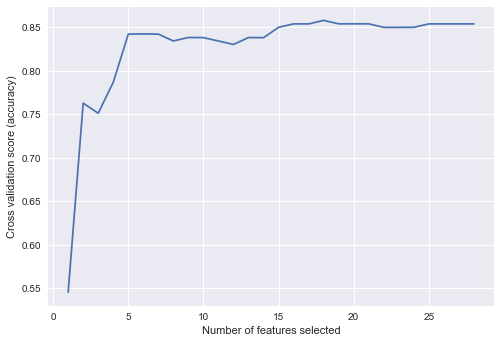

SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [34]:
model = SVC(C = 100, coef0 = 0, degree = 2, gamma = 'scale',kernel= 'linear',probability = True,class_weight = 'balanced')
selected_features_svm, highest_score_svm, best_model_svm, rfecv_svm = execute_model_fit_with_rfe_cv(model,X_train_norm,y_train,score = 'accuracy',verbose = 2)
best_model_svm.fit(X_train_norm[selected_features_svm],y_train)

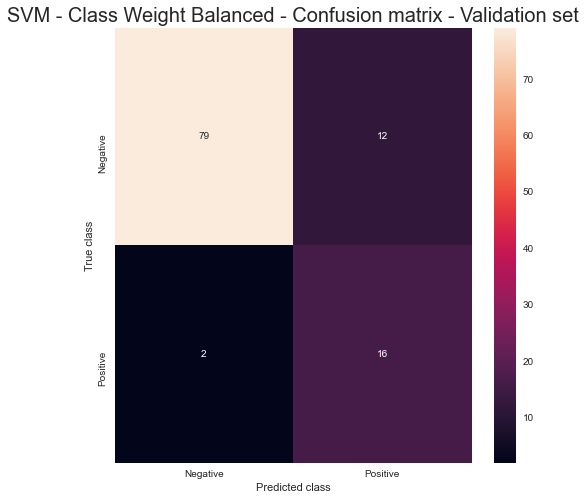

precision    recall  f1-score   support

    Negative       0.98      0.87      0.92        91
    Positive       0.57      0.89      0.70        18

    accuracy                           0.87       109
   macro avg       0.77      0.88      0.81       109
weighted avg       0.91      0.87      0.88       109

No Skill: ROC AUC=0.500
SVM - Class Weight Balanced : ROC AUC=0.888


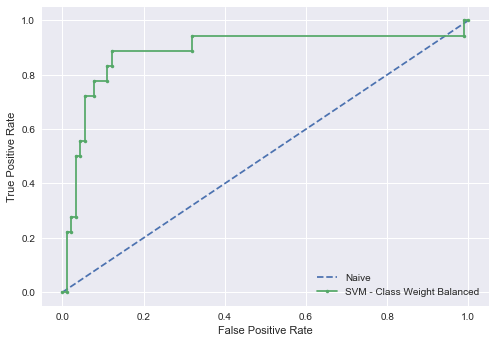

['saves/svm_no_imputation.bin']

In [35]:
df_result = model_utils.predict(best_model_svm,X_validation_norm[selected_features_svm],y_validation);
metrics_utils.evalute_model_performance(best_model_svm, 'SVM - Class Weight Balanced',X_validation_norm[selected_features_svm],y_validation,df_result)
dump(best_model_svm, 'saves/svm_no_imputation.bin', compress=True)

### SVM - without class_weight balanced

Optimal number of features : 8
highest score:  0.9130980392156862


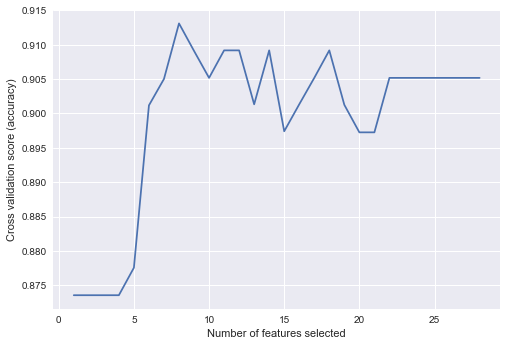

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [36]:
model = SVC(C = 100, coef0 = 0, degree = 2, gamma = 'scale', kernel= 'linear', probability = True)
selected_features_svm_no_balance, highest_score_svm_no_balance, best_model_svm_no_balance, rfecv_svm_no_balance = execute_model_fit_with_rfe_cv(model,X_train_norm,y_train,score = 'accuracy',verbose = 2)
best_model_svm_no_balance.fit(X_train_norm[selected_features_svm_no_balance],y_train)

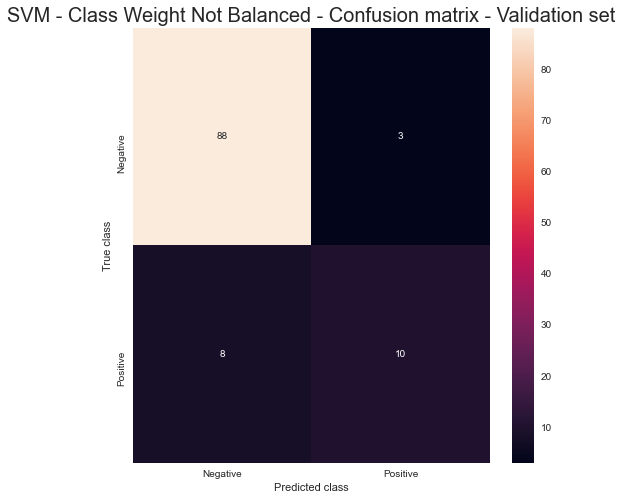

precision    recall  f1-score   support

    Negative       0.92      0.97      0.94        91
    Positive       0.77      0.56      0.65        18

    accuracy                           0.90       109
   macro avg       0.84      0.76      0.79       109
weighted avg       0.89      0.90      0.89       109

No Skill: ROC AUC=0.500
SVM - Class Weight Not Balanced : ROC AUC=0.874


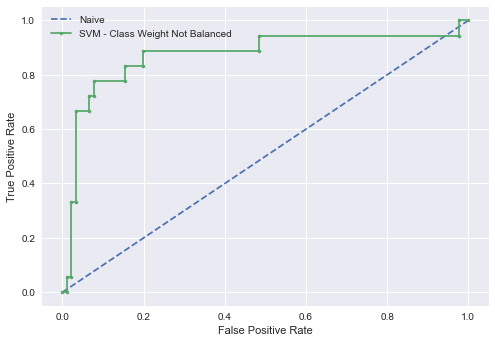

['saves/svm_no_imputation.bin']

In [37]:
df_result = model_utils.predict(best_model_svm_no_balance,X_validation_norm[selected_features_svm_no_balance],y_validation);
metrics_utils.evalute_model_performance(best_model_svm_no_balance, 'SVM - Class Weight Not Balanced',X_validation_norm[selected_features_svm_no_balance],y_validation,df_result)
dump(best_model_svm_no_balance, 'saves/svm_no_imputation.bin', compress=True)

### Logistic Regression - with class_weight balanced

Optimal number of features : 6
highest score:  0.8576470588235294


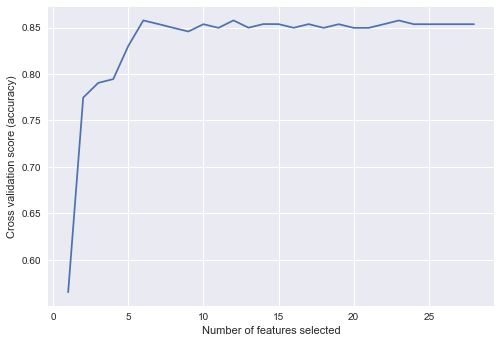

LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
model = LogisticRegression(C = 100, penalty = 'l2',class_weight = 'balanced');
selected_features_lr, highest_score_lr, best_model_lr, rfecv_lr = execute_model_fit_with_rfe_cv(model,X_train_norm,y_train,verbose = 2,score = 'accuracy')
best_model_lr.fit(X_train_norm[selected_features_lr],y_train.values.ravel())

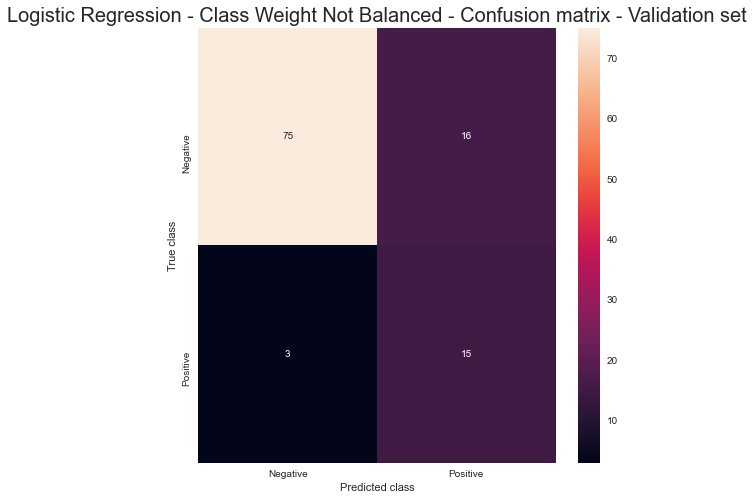

precision    recall  f1-score   support

    Negative       0.96      0.82      0.89        91
    Positive       0.48      0.83      0.61        18

    accuracy                           0.83       109
   macro avg       0.72      0.83      0.75       109
weighted avg       0.88      0.83      0.84       109

No Skill: ROC AUC=0.500
Logistic Regression - Class Weight Not Balanced : ROC AUC=0.880


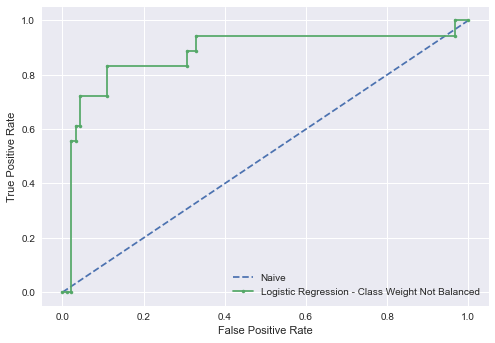

['saves/logistic_regression_no_imputation.bin']

In [39]:
df_result = model_utils.predict(best_model_lr,X_validation_norm[selected_features_lr],y_validation);
metrics_utils.evalute_model_performance(best_model_lr, 'Logistic Regression - Class Weight Not Balanced',X_validation_norm[selected_features_lr],y_validation,df_result)
dump(best_model_lr, 'saves/logistic_regression_no_imputation.bin', compress=True)

### Logistic Regression - without class_weight balanced

Optimal number of features : 25
highest score:  0.9247843137254902


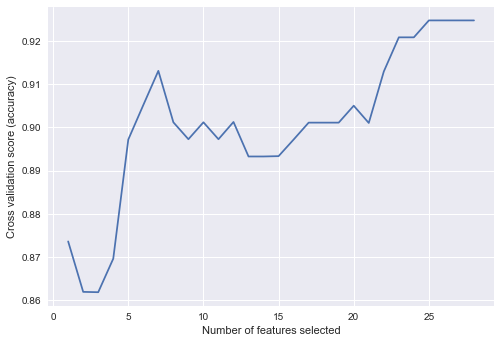

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
model = LogisticRegression(C = 100, penalty = 'l2');
selected_features_lr_no_balance, highest_score_lr_no_balance, best_model_lr_no_balance, rfecv_lr_no_balance = execute_model_fit_with_rfe_cv(model,X_train_norm,y_train,verbose = 2,score = 'accuracy')
best_model_lr_no_balance.fit(X_train_norm[selected_features_lr_no_balance],y_train.values.ravel())

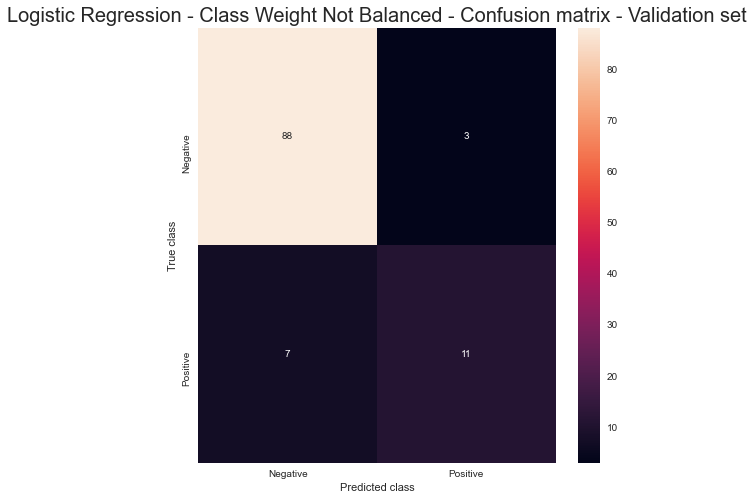

precision    recall  f1-score   support

    Negative       0.93      0.97      0.95        91
    Positive       0.79      0.61      0.69        18

    accuracy                           0.91       109
   macro avg       0.86      0.79      0.82       109
weighted avg       0.90      0.91      0.90       109

No Skill: ROC AUC=0.500
Logistic Regression - Class Weight Not Balanced : ROC AUC=0.900


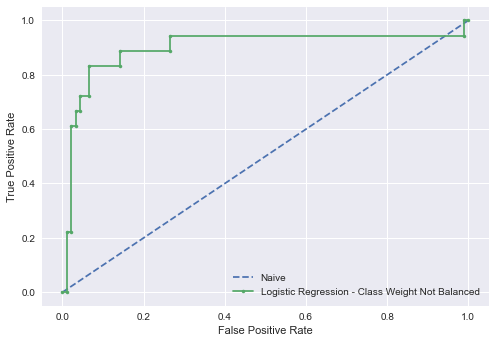

['saves/logistic_regression_no_imputation.bin']

In [41]:
df_result = model_utils.predict(best_model_lr_no_balance,X_validation_norm[selected_features_lr_no_balance],y_validation);
metrics_utils.evalute_model_performance(best_model_lr_no_balance, 'Logistic Regression - Class Weight Not Balanced',X_validation_norm[selected_features_lr_no_balance],y_validation,df_result)
dump(best_model_lr_no_balance, 'saves/logistic_regression_no_imputation.bin', compress=True)

## Visualizing weights of trained models

### SVM

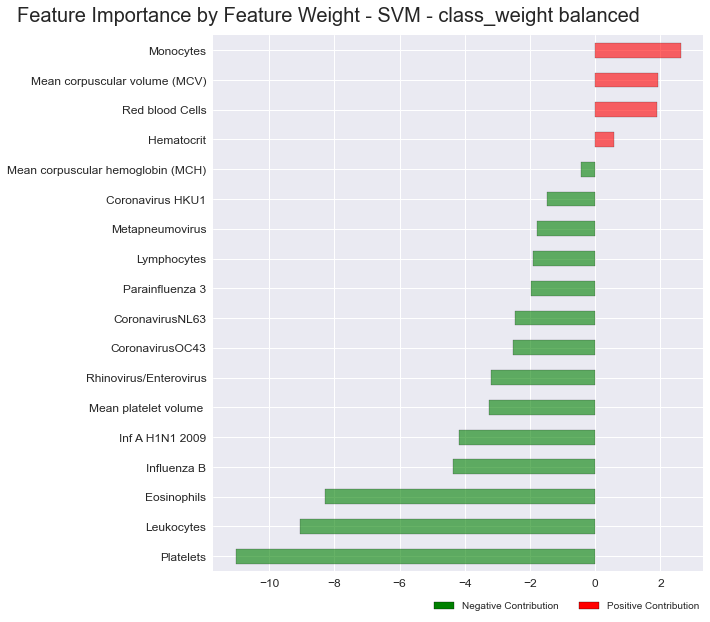

In [46]:
df_weights = feature_importance_utils.create_feature_importance_by_feature_weight(features = selected_features_svm,model = best_model_svm)
feature_importance_utils.show_feature_importance_by_feature_weight(df_weights,'SVM - class_weight balanced', color = ('r','g'), absolute_values = False,feature_importance = False)

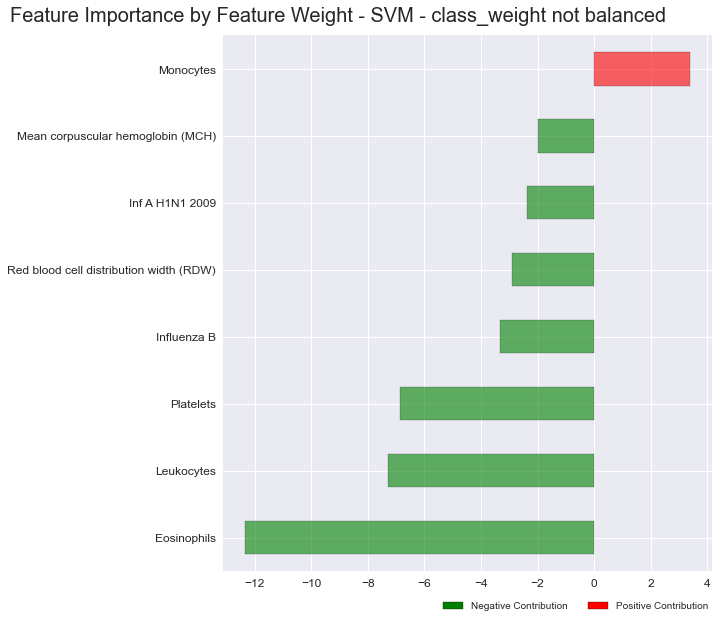

In [47]:
df_weights = feature_importance_utils.create_feature_importance_by_feature_weight(features = selected_features_svm_no_balance,model = best_model_svm_no_balance)
feature_importance_utils.show_feature_importance_by_feature_weight(df_weights,'SVM - class_weight not balanced', color = ('r','g'), absolute_values = False,feature_importance = False)

### Logistic Regression

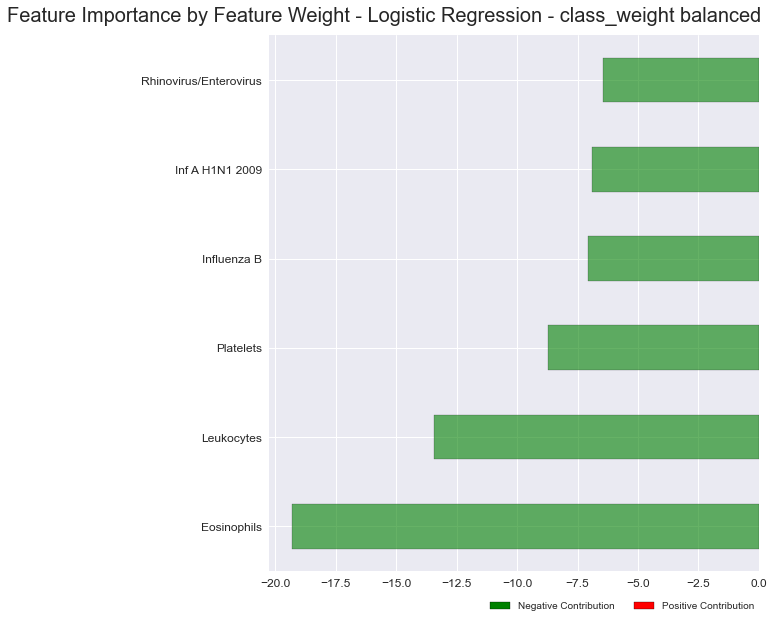

In [48]:
df_weights = feature_importance_utils.create_feature_importance_by_feature_weight(features = selected_features_lr,model = best_model_lr)
feature_importance_utils.show_feature_importance_by_feature_weight(df_weights,'Logistic Regression - class_weight balanced', color = ('r','g'), absolute_values = False,feature_importance = False)

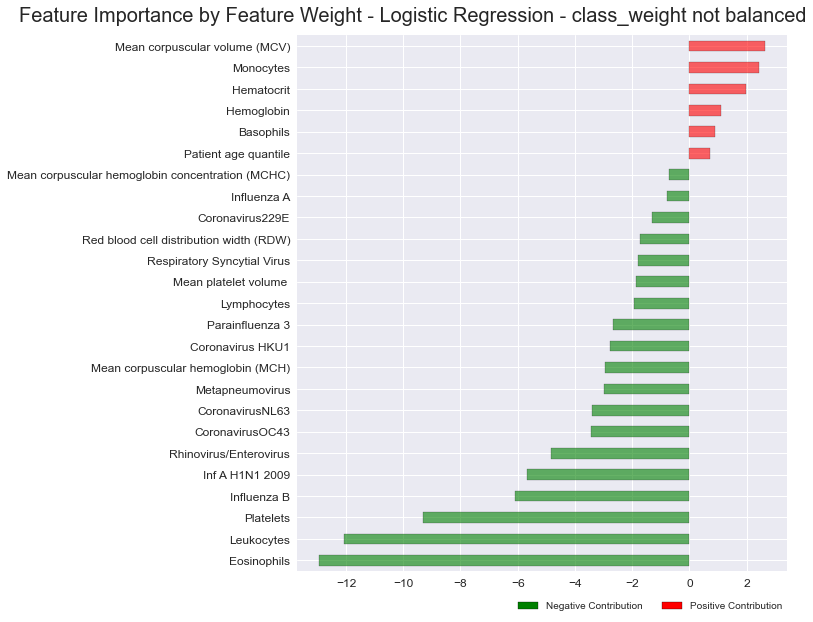

In [49]:
df_weights = feature_importance_utils.create_feature_importance_by_feature_weight(features = selected_features_lr_no_balance,model = best_model_lr_no_balance)
feature_importance_utils.show_feature_importance_by_feature_weight(df_weights,'Logistic Regression - class_weight not balanced', color = ('r','g'), absolute_values = False,feature_importance = False)